# BatchIterator

In [36]:
# !pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main

In [37]:
import albumentations as A

In [38]:
# A.__version__

In [3]:
# import os
# if os.name =='nt':
#     os.add_dll_directory(r"C:\Program Files\openslide\bin") # windows
# from wholeslidedata.iterators import create_batch_iterator
# from wholeslidedata.visualization.plotting import plot_batch
# from dicfg.magics import ConfigMagics
# from wholeslidedata.samplers.callbacks import BatchCallback
# from wholeslidedata.samplers.utils import crop_data

# from batchgenerators.transforms.abstract_transforms import AbstractTransform, Compose
# from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, \
#     ContrastAugmentationTransform, GammaTransform
# from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
# from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
# from batchgenerators.transforms.spatial_transforms import SpatialTransform, MirrorTransform
# from batchgenerators.transforms.utility_transforms import RemoveLabelTransform, RenameTransform, NumpyToTensor

# # This will allow loading yaml in an notebook cell
# ConfigMagics.register_magics()

# import matplotlib.pyplot as plt

# import numpy as np

# from multiprocessing import freeze_support

# import time

In [4]:
import os
import numpy as np
import torch
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
from batchgenerators.utilities.file_and_folder_operations import join, load_json

# Whole slide data dataloader
if os.name == 'nt':
    os.add_dll_directory(r"C:\Program Files\openslide\bin") # windows
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.iterators.batchiterator import BatchIterator
from wholeslidedata.samplers.utils import crop_data
# from nnunetv2.training.nnUNetTrainer.variants.pathology import wsd_pathology_DA_callback
from copy import deepcopy

# for network building
from torch import nn
from dynamic_network_architectures.architectures.unet import ResidualEncoderUNet, PlainConvUNet
from dynamic_network_architectures.building_blocks.helper import convert_dim_to_conv_op, get_matching_batchnorm
from dynamic_network_architectures.initialization.weight_init import init_last_bn_before_add_to_0, InitWeights_He
from nnunetv2.utilities.plans_handling.plans_handler import ConfigurationManager, PlansManager


# for def on_train_start:
from batchgenerators.utilities.file_and_folder_operations import join, save_json, maybe_mkdir_p, isfile
from torch import distributed as dist
from nnunetv2.training.dataloading.utils import unpack_dataset
from nnunetv2.utilities.default_n_proc_DA import get_allowed_n_proc_DA
from nnunetv2.utilities.helpers import empty_cache

#for dummy init
from nnunetv2.utilities.label_handling.label_handling import determine_num_input_channels
# for super init
from nnunetv2.training.logging.nnunet_logger import nnUNetLogger
from datetime import datetime
from torch.cuda.amp import GradScaler
import inspect
from torch.cuda import device_count
from nnunetv2.paths import nnUNet_results, nnUNet_preprocessed

# for splits
from sklearn.model_selection import KFold

# for timing
import time

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_raw
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_preprocessed
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nn

In [5]:
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"

def convert_path(path, to=current_os):
    if to in ["w", "win", "windows"]:
        path = path.replace("/mnt/pa_cpg", "Y:")
        path = path.replace("/data/pathology", "Z:")
        path = path.replace("/mnt/pa_cpgarchive1", "W:")
        path = path.replace("/mnt/pa_cpgarchive2", "X:")
        path = path.replace("/", "\\")
    if to in ["u", "unix", "l", "linux"]:
        path = path.replace("Y:", "/mnt/pa_cpg")
        path = path.replace("Z:", "/data/pathology")
        path = path.replace("W:", "/mnt/pa_cpgarchive1")
        path = path.replace("X:", "/mnt/pa_cpgarchive2")
        path = path.replace("\\", "/")
    return path

In [6]:
from nnunetv2.paths import nnUNet_results, nnUNet_preprocessed

In [7]:
self_plans_manager_dataset_name = 'Dataset004_TIGER_split'
self_fold = 0
self_dataset_json = load_json(convert_path(r"Z:\projects\pathology-lung-TIL\nnUNet_v2\data\nnUNet_preprocessed\Dataset004_TIGER_split\dataset.json"))

In [8]:
def do_split():
    if isfile(join(nnUNet_preprocessed, self_plans_manager_dataset_name, 'splits.json')):
        splits_json_path = join(nnUNet_preprocessed, self_plans_manager_dataset_name, 'splits.json')
        self_splits_json = load_json(splits_json_path)
        print('Found splits.json')
    else:
        print("Didn't find splits.json, making random 5-fold split now")
        files_json = load_json(join(nnUNet_preprocessed, self_plans_manager_dataset_name, 'files.json'))
        num_training_files = len(files_json['training'])
        k5 = KFold(n_splits=5, shuffle=True) 

        # get split indexes per fold
        split_dict = {}
        for fold, indexes in enumerate(k5.split(range(num_training_files))):
            split_dict[fold] = indexes

        # make split dict with file paths
        splits_json = {}
        for fold in range(5):
            train_idx, val_idx = split_dict[fold]
            train_split = list(np.array(files_json['training'])[train_idx])
            val_split = list(np.array(files_json['training'])[val_idx])
            fold_dict = {'training': train_split,
                         'validation': val_split
                        }
            splits_json[fold] = fold_dict

        # save
        splits_json_path = join(nnUNet_preprocessed, self_plans_manager_dataset_name, 'splits.json')
        self_splits_json = splits_json
        with open(splits_json_path, 'w') as file:
            save_json(self_splits_json, file)

In [9]:
def get_dataloaders():
    
    patch_size = [512, 512]
    batch_size = 17
    normalization_schemes = ['RGBTo01Normalization', 'RGBTo01Normalization', 'RGBTo01Normalization']
    self_device = torch.device('cuda')
    do_split()

    # return None, None
    print('[Getting WSD dataloaders]')
    self_sample_double = False # this means we for example sample 1024x1024, augment, and return 512x512 center crop to remove artifacts induced by zooming and rotating
    self_time = True
    self_albumentations_aug = True

    if self_albumentations_aug:
        iterator_template_path = join(os.getcwd(), 'wsd_iterator_alb_aug_template.json')
    else:
        iterator_template_path = join(os.getcwd(), 'wsd_iterator_template.json')
    print(f'Using iterator template: {iterator_template_path}')
    iterator_template = load_json(iterator_template_path)
    split_json = load_json(join(nnUNet_preprocessed, self_plans_manager_dataset_name, 'splits.json'))
    fold_split_dict = split_json[str(self_fold)]
    if self_time:
        print('Still timing everything, only copying SOME training and val files')
        fold_split_dict = {'training': fold_split_dict['training'][-30:], 'validation': fold_split_dict['validation'][-20:]}
    copy_path = '/home/user' #'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_wsd'
    labels = self_dataset_json['labels']
    label_sample_weights = {
        'invasive tumor': 0.5,
        'tumor-associated stroma': 0.5
    }
    spacing = 0.5

    patch_size = list(patch_size)
    batch_size = batch_size
    ds_scales = [[1.0, 1.0],
         [0.5, 0.5],
         [0.25, 0.25],
         [0.125, 0.125],
         [0.0625, 0.0625],
         [0.03125, 0.03125],
         [0.015625, 0.015625]]
    ds_shapes = [[int(np.round(i * j)) for i, j in zip(patch_size, k)] for k in ds_scales]
    # extra_ds_sizes = [ds_shape for ds_shape in ds_shapes[1:]]
    # extra_ds_shapes = tuple([tuple([batch_size]+ds_shape) for ds_shape in ds_shapes[1:]])

    if self_sample_double:
        patch_size = [size*2 for size in patch_size]
        patch_shape = patch_size + [len(normalization_schemes)]
        ds_sizes = [[shape*2 for shape in ds_shape] for ds_shape in ds_shapes]
        extra_ds_sizes = ds_sizes[1:]
        ds_shapes = tuple([tuple([batch_size]+[shape*2 for shape in ds_shape]) for ds_shape in ds_shapes])
        extra_ds_shapes = ds_shapes[1:]
    else:
        patch_shape = patch_size + [len(normalization_schemes)]
        ds_sizes = [ds_shape for ds_shape in ds_shapes]
        extra_ds_sizes = ds_sizes[1:]
        ds_shapes = tuple([tuple([batch_size]+ds_shape) for ds_shape in ds_shapes])
        extra_ds_shapes = ds_shapes[1:]

    device = self_device

    fill_template = iterator_template['wholeslidedata']['default']
    fill_template['yaml_source'] = fold_split_dict
    fill_template['labels'] = labels
    fill_template['batch_shape']['batch_size'] = batch_size
    fill_template['batch_shape']['spacing'] = spacing
    fill_template['batch_shape']['shape'] = patch_shape
    fill_template['label_sampler']['labels'] = label_sample_weights
    if not self_albumentations_aug:
        fill_template['batch_callbacks'][0]['patch_size_spatial'] = patch_size
    fill_template['batch_callbacks'][-1]['sizes'] = extra_ds_sizes
    fill_template['dataset']['copy_path'] = copy_path

    self_train_config = iterator_template

    save_json(self_train_config, join('test_folder_mart', 'train_config.json'), sort_keys=False)

    self_val_config = deepcopy(iterator_template)
    del self_val_config['wholeslidedata']['default']['batch_callbacks'][0] # remove data augmentation for validation

    def half_crop(data):
        cropx = (data.shape[1] - data.shape[1]//2) // 2
        cropy = (data.shape[2] - data.shape[2]//2) // 2
        if len(data.shape) == 3:
            return data[:, cropx:-cropx, cropy:-cropy]
        if len(data.shape) == 4:
            return data[:, cropx:-cropx, cropy:-cropy, :]

    class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
        def __next__(self):
            x_batch, y_batch, *extras, _ = super().__next__()

            data = torch.FloatTensor(x_batch.transpose(0,3,1,2) /255.).to(device)
            target = [torch.FloatTensor(np.expand_dims(y_batch, 1)).to(device)] + [
                torch.FloatTensor(np.expand_dims(extra, 1)).to(device) 
                for extra in extras]         
            return {'data': data, 'target': target}

    class WholeSlidePlainnnUnetHalfCropBatchIterator(BatchIterator):
        def __next__(self):
            x_batch, y_batch, *extras, _ = super().__next__()
            x_batch = half_crop(x_batch)
            y_batch = half_crop(y_batch)
            extras = [half_crop(extra) for extra in extras]

            data = torch.FloatTensor(x_batch.transpose(0,3,1,2) /255.).to(device)
            target = [torch.FloatTensor(np.expand_dims(y_batch, 1)).to(device)] + [
                torch.FloatTensor(np.expand_dims(extra, 1)).to(device) 
                for extra in extras]         
            return {'data': data, 'target': target}


    class WholeSlidePlainnnUnetBatchIteratorTIME(BatchIterator):
        def __next__(self):
            start_time = time.time()

            x_batch, y_batch, *extras, _ = super().__next__()
            line1_time = time.time() - start_time

            start_time = time.time()
            data = torch.FloatTensor(x_batch.transpose(0, 3, 1, 2) / 255.).to(device)
            line2_time = time.time() - start_time

            start_time = time.time()
            target = [torch.FloatTensor(np.expand_dims(y_batch, 1)).to(device)] + [
                torch.FloatTensor(np.expand_dims(extra, 1)).to(device)
                for extra in extras]
            line3_time = time.time() - start_time

            print("Time taken for NEXT:\t\t\t\t\t\t", line1_time)
            print("Time taken TOTAL:\t\t\t\t\t\t\t\t\t\t", line1_time + line2_time + line3_time)

            return {'data': data, 'target': target}

    class WholeSlidePlainnnUnetHalfCropBatchIteratorTIME(BatchIterator):
        def __next__(self):
            start_time = time.time()
            x_batch, y_batch, *extras, _ = super().__next__()
            line1_time = time.time() - start_time

            start_time = time.time()
            x_batch = half_crop(x_batch)
            line2_time = time.time() - start_time

            start_time = time.time()
            y_batch = half_crop(y_batch)
            line3_time = time.time() - start_time

            start_time = time.time()
            extras = [half_crop(extra) for extra in extras]
            line4_time = time.time() - start_time

            start_time = time.time()
            data = torch.FloatTensor(x_batch.transpose(0, 3, 1, 2) / 255.).to(device)
            line5_time = time.time() - start_time

            start_time = time.time()
            target = [torch.FloatTensor(np.expand_dims(y_batch, 1)).to(device)] + [
                torch.FloatTensor(np.expand_dims(extra, 1)).to(device)
                for extra in extras]
            line6_time = time.time() - start_time

            print("Time taken for NEXT:", line1_time)
            print("Time taken TOTAL:", line1_time + line2_time + line3_time + line4_time + line5_time + line6_time)

            return {'data': data, 'target': target}

    if self_time:
        iterator_class = WholeSlidePlainnnUnetHalfCropBatchIteratorTIME if self_sample_double else WholeSlidePlainnnUnetBatchIteratorTIME
    else:
        iterator_class = WholeSlidePlainnnUnetHalfCropBatchIterator if self_sample_double else WholeSlidePlainnnUnetBatchIterator

    # TODO: multiprocessing num cpus -2    
    cpus = 12
    print('[Creating batch iterators]')
    print('\t[Creating TRAIN batch iterator]')
    tiger_train_batch_iterator = create_batch_iterator(mode="training",
                                    user_config= deepcopy(self_train_config),
                                    cpus=cpus,
                                    buffer_dtype='uint8',
                                    extras_shapes = extra_ds_shapes,
                                    iterator_class=iterator_class)

    # sleep = 30
    # print(f"\t...Sleep {sleep}s...")
    # time.sleep(sleep)
    
    print('\t[Creating VAL batch iterator]')
    tiger_val_batch_iterator = create_batch_iterator(mode="validation",
                            user_config= deepcopy(self_val_config),
                            cpus=cpus,
                            buffer_dtype='uint8',
                            extras_shapes = extra_ds_shapes,
                            iterator_class=iterator_class)


    print('[Returning batch iterators]')
    return tiger_train_batch_iterator, tiger_val_batch_iterator
    # return tiger_val_batch_iterator, tiger_val_batch_iterator
    # return tiger_train_batch_iterator, tiger_train_batch_iterator

In [10]:
tr_it, val_it = get_dataloaders()

Found splits.json
[Getting WSD dataloaders]
Using iterator template: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/test_code/wsd_iterator_alb_aug_template.json
Still timing everything, only copying SOME training and val files
[Creating batch iterators]
	[Creating TRAIN batch iterator]
	[Creating VAL batch iterator]
[Returning batch iterators]


In [11]:
batch = next(tr_it)

Time taken for NEXT:						 0.03127312660217285
Time taken TOTAL:										 1.873748540878296


In [45]:
%matplotlib inline

In [46]:
import matplotlib.pyplot as plt

Time taken for NEXT:						 0.009453296661376953
Time taken TOTAL:										 0.12286210060119629


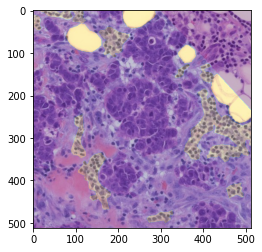

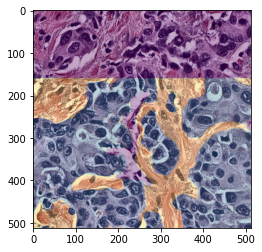

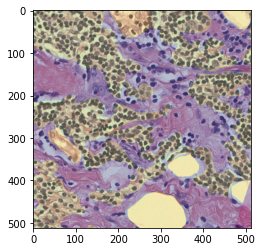

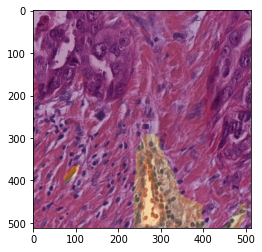

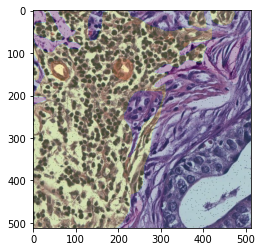

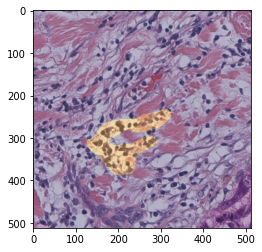

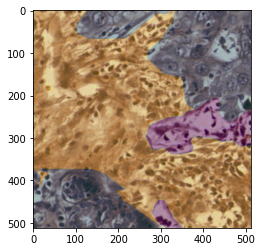

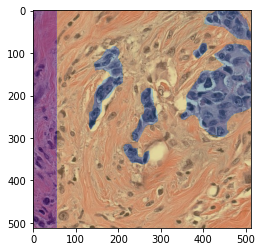

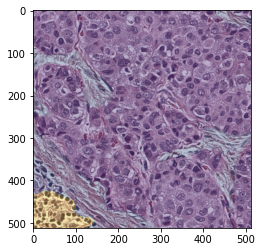

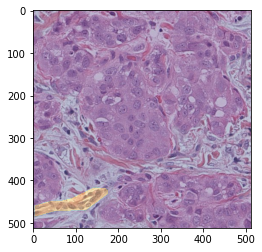

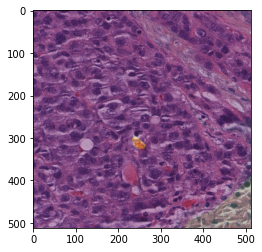

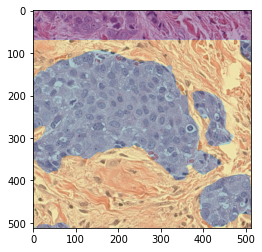

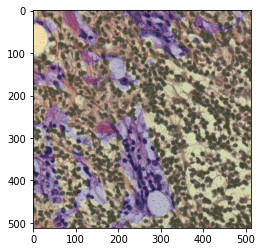

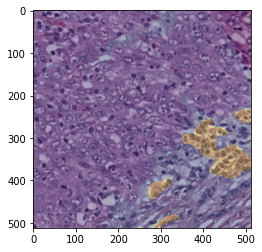

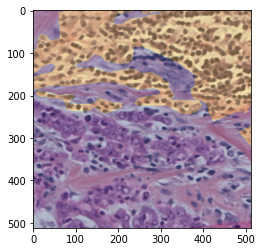

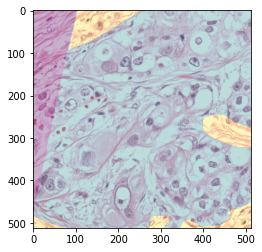

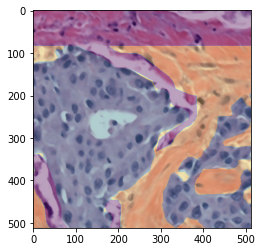

In [58]:
batch = next(tr_it)
for i in range(17):
    plt.imshow(batch['data'].permute(0, 2, 3, 1).cpu().numpy()[i])
    plt.imshow(batch['target'][0][i][0].cpu().numpy(), alpha=0.3)
    plt.show()

In [50]:
[i.shape for i in batch['target']]

[torch.Size([17, 1, 512, 512]),
 torch.Size([17, 1, 256, 256]),
 torch.Size([17, 1, 128, 128]),
 torch.Size([17, 1, 64, 64]),
 torch.Size([17, 1, 32, 32]),
 torch.Size([17, 1, 16, 16]),
 torch.Size([17, 1, 8, 8])]

In [43]:
plt.imshow((batch['data'].permute(0, 2, 3, 1).cpu().numpy()[0]*255).astype('uint8'))

In [32]:
batch['data'].permute(0, 2, 3, 1).cpu()[0].shape

torch.Size([512, 512, 3])

In [4]:
# pip3 install -e /data/pathology/projects/pathology-lung-TIL/nnUNet_v2
from nnunetv2.training.data_augmentation.custom_transforms.pathology_transforms import HedTransform, HsvTransform, Clip01

In [5]:
from wholeslidedata.iterators.batchiterator import BatchIterator

# class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
#     def __next__(self):
#         x_batch, y_batch, _ = super().__next__()
#         x_batch = x_batch.transpose(0,3,1,2).astype('float32')#/255
#         y_batch = y_batch.astype('int16')
#         return {'data': x_batch, 'seg': y_batch}

In [6]:
import torch

In [5]:
class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
    def __next__(self):
        x_batch, y_batch, *extras, _ = super().__next__()
        x_batch = crop_data(x_batch, [512, 512])
        y_batch = crop_data(np.expand_dims(y_batch, -1), [512, 512]).squeeze()
        print(self_patch_size)

        data = torch.FloatTensor(x_batch.transpose(0,3,1,2) /255.).to(device)
        target = [torch.FloatTensor(np.expand_dims(y_batch, 1)).to(device)] + [
            torch.FloatTensor(np.expand_dims(extra, 1)).to(device) 
            for extra in extras]         
        return {'data': data, 'target': target}

In [6]:
class Check(AbstractTransform):
    def __init__(self, data_key="data", label_key="seg", property_key="properties", p_per_sample=1, string=''):
        self_data_key = data_key
        self_label_key = label_key
        self_property_key = property_key
        self_string = string
    def __call__(self, **data_dict):
        data = data_dict.get(self_data_key)
#         end_time = time.time()

#         if start_time:
#             execution_time = end_time - start_time
        
        # Line of code to time
        
        # print(np.min(data), np.max(data))
        # print(data.dtype)
        # seg = data_dict.get(self_label_key)
        # props = data_dict.get(self_property_key)
        if self_string:
            print(self_string)
        # print('\t\t\t', execution_time)

            
        # print('\n\n\nPROPERTIES BEFORE TRANSFORMS', props, '\n\n\n')
        return data_dict
###

In [7]:
class nnUnetBatchCallback(BatchCallback):
    
    # patch_size_spatial (width/height)
    def __init__(self, patch_size_spatial, check=True):
        tr_transforms = []
        rotation_for_DA= {'x': (-3.141592653589793, 3.141592653589793), 'y': (0, 0), 'z': (0, 0)}
        
        if check:
            tr_transforms.append(Check())
        
        tr_transforms.append(SpatialTransform(
            patch_size_spatial, 
            patch_center_dist_from_border=None,
            do_elastic_deform=False,
            alpha=(0, 0),
            sigma=(0, 0),
            do_rotation=True,
            angle_x=rotation_for_DA['x'],
            angle_y=rotation_for_DA['y'],
            angle_z=rotation_for_DA['z'],
            p_rot_per_axis=1,  # todo experiment with this
            do_scale=True,
            scale=(0.7, 1.4),
            border_mode_data="constant",
            border_cval_data=0,
            order_data=3,
            border_mode_seg="constant",
            border_cval_seg=-1,
            order_seg=1,
            random_crop=False,  # random cropping is part of our dataloaders
            p_el_per_sample=0,
            p_scale_per_sample=0.2,
            p_rot_per_sample=0.2,
            independent_scale_for_each_axis=False  # todo experiment with this
        ))

        if check:
            tr_transforms.append(Check(string='^ spatial'))
        
        ####
        if True: #do_hed:
            tr_transforms.append(HedTransform(factor=0.05))
        # if True: #do_hsv:
        #     tr_transforms.append(HsvTransform(h_lim=0.10, s_lim=0.10, v_lim=0.10))
        ####
        
        tr_transforms.append(GaussianNoiseTransform(p_per_sample=0.1))
        
        if check:
            tr_transforms.append(Check())
        
        tr_transforms.append(GaussianBlurTransform((0.5, 1.), different_sigma_per_channel=True, p_per_sample=0.2,
                                                   p_per_channel=0.5))
        
        if check:
            tr_transforms.append(Check(string='^ gauss noise and blur'))
        
        tr_transforms.append(BrightnessMultiplicativeTransform(multiplier_range=(0.75, 1.25), p_per_sample=0.15))
        
        if check:
            tr_transforms.append(Check(string='^ bright'))
        
        
        
        tr_transforms.append(ContrastAugmentationTransform(p_per_sample=0.15))
        
        if check:
            tr_transforms.append(Check(string='^ cont'))
            
        tr_transforms.append(SimulateLowResolutionTransform(zoom_range=(0.5, 1), per_channel=True,
                                                            p_per_channel=0.5,
                                                            order_downsample=0, order_upsample=3, p_per_sample=0.25,
                                                            ignore_axes=None))
        
        if check:
            tr_transforms.append(Check(string='^ res'))
            
        tr_transforms.append(GammaTransform((0.7, 1.5), True, True, retain_stats=True, p_per_sample=0.1))
        
        if check:
            tr_transforms.append(Check())
            
        tr_transforms.append(GammaTransform((0.7, 1.5), False, True, retain_stats=True, p_per_sample=0.3))
        
        if check:
            tr_transforms.append(Check(string='^ gamm'))
        
        tr_transforms.append(Clip01())
        
        tr_transforms.append(MirrorTransform((0,1)))
        
        if check:
            tr_transforms.append(Check())
            
        tr_transforms.append(RemoveLabelTransform(-1, 0))
        
        if check:
            tr_transforms.append(Check(string='^ mir, rem lab'))
            
        tr_transforms.append(RenameTransform('seg', 'target', True))
        
        
        self__transforms = Compose(tr_transforms)
    
    def __call__(self, x_batch, y_batch):
        # format to nnUNet
        x_batch = np.stack([x/255  for x in x_batch]).transpose((0, 3, 1, 2)).astype('float32')
        y_batch = np.expand_dims(np.stack(y_batch).astype('int8'), 1)
        
        # transform
        batch = self__transforms(**{'data': x_batch, 'seg': y_batch})
        
        # format back to wsd
        x_batch, y_batch = batch['data'], batch['target']
        x_batch = np.multiply(x_batch, 255).astype(np.uint8)
        return x_batch.transpose((0, 2, 3, 1)), y_batch.squeeze()

In [8]:
#     def get_validation_transforms(deep_supervision_scales: Union[List, Tuple],
#                                   is_cascaded: bool = False,
#                                   foreground_labels: Union[Tuple[int, ...], List[int]] = None,
#                                   regions: List[Union[List[int], Tuple[int, ...], int]] = None,
#                                   ignore_label: int = None) -> AbstractTransform:
#         val_transforms = []
#         val_transforms.append(RemoveLabelTransform(-1, 0))

#         if is_cascaded:
#             val_transforms.append(MoveSegAsOneHotToData(1, foreground_labels, 'seg', 'data'))

#         val_transforms.append(RenameTransform('seg', 'target', True))

#         if regions is not None:
#             # the ignore label must also be converted
#             val_transforms.append(ConvertSegmentationToRegionsTransform(list(regions) + [ignore_label]
#                                                                         if ignore_label is not None else regions,
#                                                                         'target', 'target'))

#         if deep_supervision_scales is not None:
#             val_transforms.append(DownsampleSegForDSTransform2(deep_supervision_scales, 0, input_key='target',
#                                                                output_key='target'))

#         val_transforms.append(NumpyToTensor(['data', 'target'], 'float'))
#         val_transforms = Compose(val_transforms)
#         return val_transforms

In [9]:
# 

:::{seealso}
 - For more information about the **mode**, please see the user guide about [modes](./modes)
 - For an explanation about the **user_config** please see the [batchiterator configuration](/userguide/index.html#batchiterator-configuration)
:::

In [10]:
# patch_size

In [11]:
%matplotlib inline

In [12]:
# %%yaml user_config 

# wholeslidedata:
#     default:
#         yaml_source:
#             training:
#             -   wsi: 
#                     path: C:\Users\joeyspronck\Documents\Other\wsirois\wsi-level-annotations\images\100B.tif
#                 wsa: 
#                     path: C:\Users\joeyspronck\Documents\Other\wsirois\wsi-level-annotations\annotations-tissue-cells-xmls\100B.xml
                        
#         labels:
#             invasive tumor: 1
#             tumor-associated stroma: 2
#             in-situ tumor: 3
#             healthy glands: 4
#             necrosis not in-situ: 5
#             inflamed stroma: 6
#             rest: 7
            
#         batch_shape:
#             batch_size: 2
#             spacing: 1.0
#             shape: [512, 512, 3]
            
#         batch_callbacks: 
#             - "*object": __main__.NNUnetBatchCallback
#               patch_size_spatial: [512,512]

In [13]:
patch_size = [512, 512]
batch_size = 2
sample_double = True

ds_scales = [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125], [0.015625, 0.015625]]
ds_shapes = [list(np.round([int(i * j) for i, j in zip(patch_size, k)])) for k in ds_scales]

if sample_double:
    ds_sizes = [[shape*2 for shape in ds_shape] for ds_shape in ds_shapes]
    extra_ds_sizes = ds_sizes[1:]
    ds_shapes = tuple([tuple([batch_size]+[shape*2 for shape in ds_shape]) for ds_shape in ds_shapes])
    extra_ds_shapes = ds_shapes[1:]
else:
    ds_sizes = [ds_shape for ds_shape in ds_shapes]
    extra_ds_sizes = ds_sizes[1:]
    ds_shapes = tuple([tuple([batch_size]+ds_shape) for ds_shape in ds_shapes])
    extra_ds_shapes = ds_shapes[1:]


In [14]:
ds_sizes, ds_shapes

([[1024, 1024],
  [512, 512],
  [256, 256],
  [128, 128],
  [64, 64],
  [32, 32],
  [16, 16]],
 ((2, 1024, 1024),
  (2, 512, 512),
  (2, 256, 256),
  (2, 128, 128),
  (2, 64, 64),
  (2, 32, 32),
  (2, 16, 16)))

In [15]:
extra_ds_sizes

[[512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]

In [34]:
%%yaml user_config 

wholeslidedata:
    default:
        backend: 
            'asap'
        
        yaml_source:
            training:
            -   wsi: 
                    path: /data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/100B.tif
                wsa: 
                    path: /data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml
                        
        labels:
            invasive tumor: 1
            tumor-associated stroma: 2
            in-situ tumor: 3
            healthy glands: 4
            necrosis not in-situ: 5
            inflamed stroma: 6
            rest: 7
            
        batch_shape:
            batch_size: 2
            spacing: 1.0
            shape: [1024, 1024, 3]
            
        batch_callbacks: 
            # - "*object": __main__.NormalizeSampleCallback
            - "*object": __main__.nnUnetBatchCallback
              patch_size_spatial: [1024,1024]
            - "*object": wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback
              sizes: [[512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]
                


In [23]:
%%yaml user_config 

wholeslidedata:
    default:
        backend: 
            'asap'
        
        yaml_source:
            training:
            -   wsi: 
                    path: /data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/100B.tif
                wsa: 
                    path: /data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml
                        
        labels:
            invasive tumor: 1
            tumor-associated stroma: 2
            in-situ tumor: 3
            healthy glands: 4
            necrosis not in-situ: 5
            inflamed stroma: 6
            rest: 7
            
        batch_shape:
            batch_size: 2
            spacing: 1.0
            shape: [1024, 1024, 3]
            
        batch_callbacks: 

    batch_callbacks:
            - "*object": wholeslidedata.interoperability.albumentations.callbacks.AlbumentationsAugmentationsCallback
              augmentations:

                # Blurring
                - AdvancedBlur:
                    p: 0.1
                - GaussianBlur:
                    p: 0.1
                - Blur:
                    p: 0.1
                - MedianBlur:
                    p: 0.1
                - GlassBlur:
                    p: 0.1

                 # Orientation
                - VerticalFlip:
                    p: 0.25
                - HorizontalFlip:
                    p: 0.25
                - RandomRotate90:
                    p: 0.25
                - Flip:
                    p: 0.25
                - Transpose:
                    p: 0.25

                # Contrast and brightness
                - RandomGamma:
                    p: 0.1

                - HueSaturationValue:
                    p: 0.1

                - RandomBrightnessContrast:
                    p: 0.1

                - CLAHE:
                    p: 0.1

                # Noise
                - ImageCompression:
                    p: 0.1

                - ISONoise:
                    p: 0.1

                - GaussNoise:
                    p: 0.1

                - MultiplicativeNoise:
                    p: 0.1

                - PixelDropout:
                    p: 0.1

            - "*object": wholeslidedata.samplers.callbacks.HedCallback
              probability: 0.5

            - "*object": wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback
              sizes: [[512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]
                


In [24]:
user_config

{'wholeslidedata': {'default': {'backend': 'asap',
   'yaml_source': {'training': [{'wsi': {'path': '/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/100B.tif'},
      'wsa': {'path': '/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml'}}]},
   'labels': {'invasive tumor': 1,
    'tumor-associated stroma': 2,
    'in-situ tumor': 3,
    'healthy glands': 4,
    'necrosis not in-situ': 5,
    'inflamed stroma': 6,
    'rest': 7},
   'batch_shape': {'batch_size': 2, 'spacing': 1.0, 'shape': [1024, 1024, 3]},
   'batch_callbacks': None},
  'batch_callbacks': [{'*object': 'wholeslidedata.interoperability.albumentations.callbacks.AlbumentationsAugmentationsCallback',
    'augmentations': [{'AdvancedBlur': {'p': 0.1}},
     {'GaussianBlur': {'p': 0.1}},
     {'Blur': {'p': 0.1}},
     {'MedianBlur': {'p': 0.1}},
     {'GlassBlur': {'p': 0.1}},
     {'VerticalFlip': {'p': 0.25}},


In [36]:
# from wholeslidedata.iterators.batchiterator import BatchIterator

# class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
#     def __next__(self):
#         x_batch, y_batch, *extras, _ = super().__next__()
#         data = x_batch.transpose(0,3,1,2).astype('float32')
#         target = [np.expand_dims(y_batch, 1).astype('int16')] + [np.expand_dims(extra, 1).astype('int16') for extra in extras]         
#         return {'data': data, 'target': target}

455
^ spatial
^ gauss noise and blur
^ bright
^ cont
^ res
^ gamm
^ mir, rem lab
0


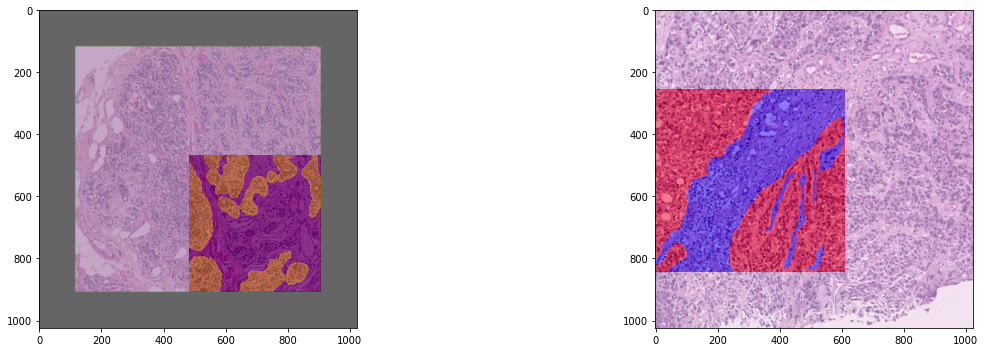

^ spatial


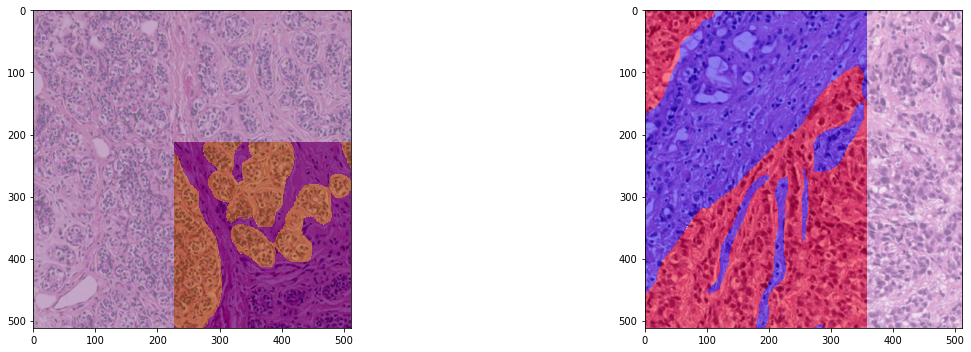

^ gauss noise and blur
^ bright
^ cont
^ res
^ gamm
^ mir, rem lab
1


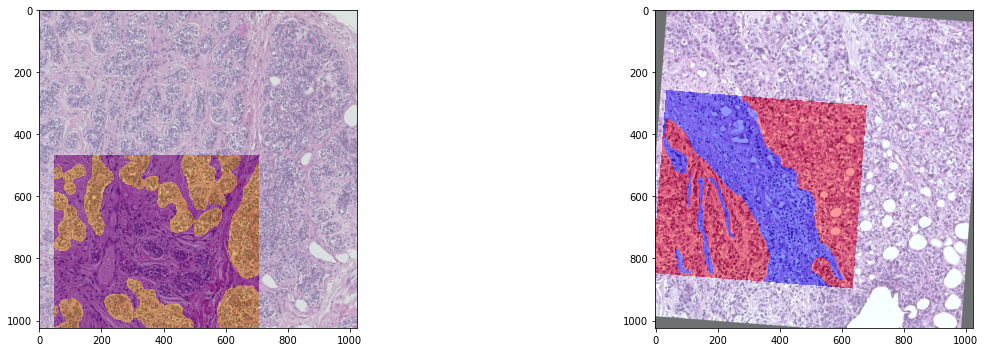

^ spatial


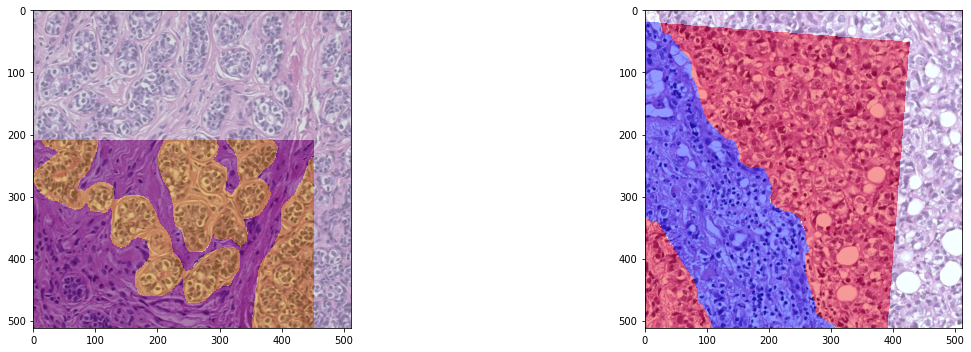

^ gauss noise and blur
^ bright
^ cont
^ res
^ gamm
^ mir, rem lab
2


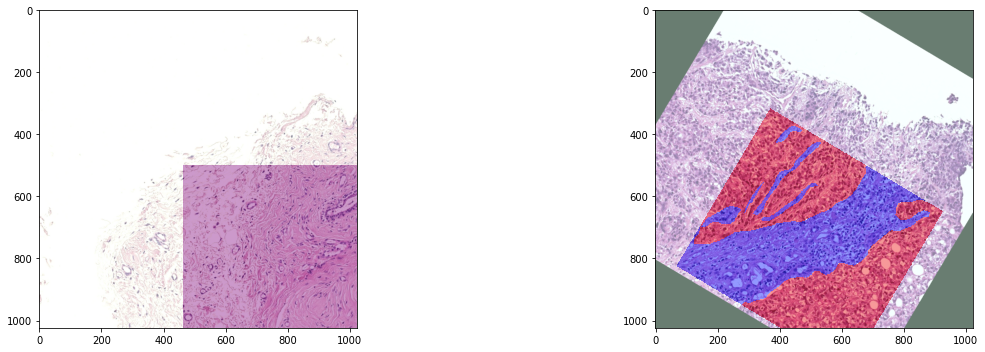

^ spatial
^ gauss noise and blur
^ bright
^ cont


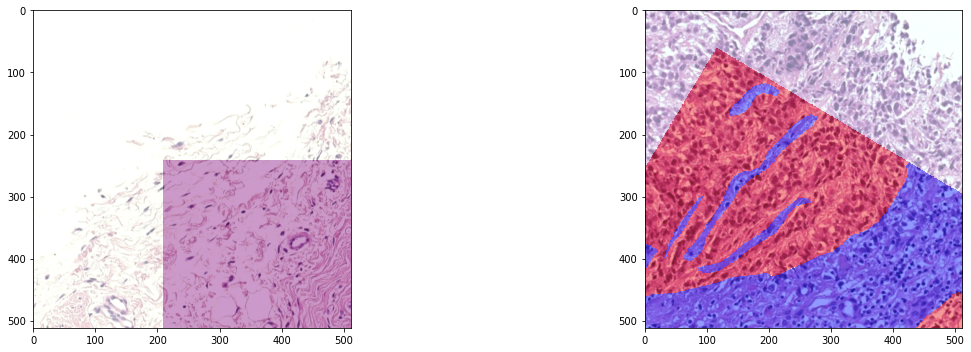

^ res
^ gamm
^ mir, rem lab
3


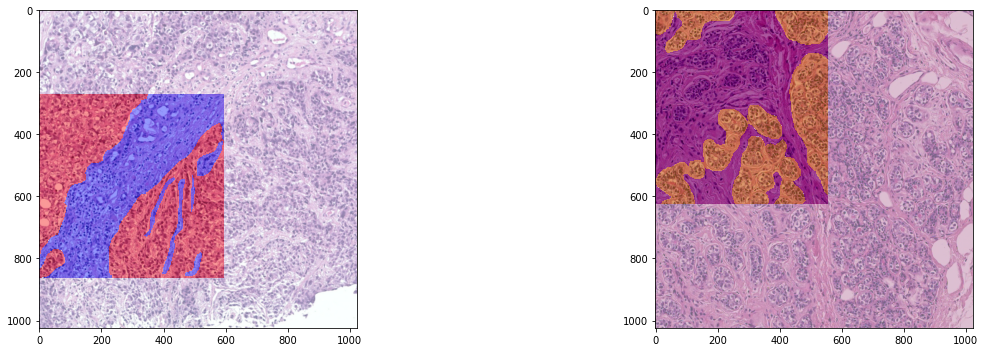

^ spatial
^ gauss noise and blur
^ bright
^ cont


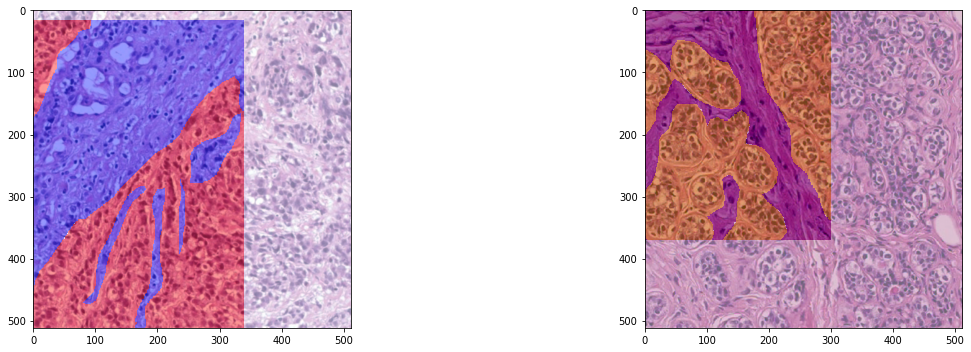

^ res
^ gamm
^ mir, rem lab
4


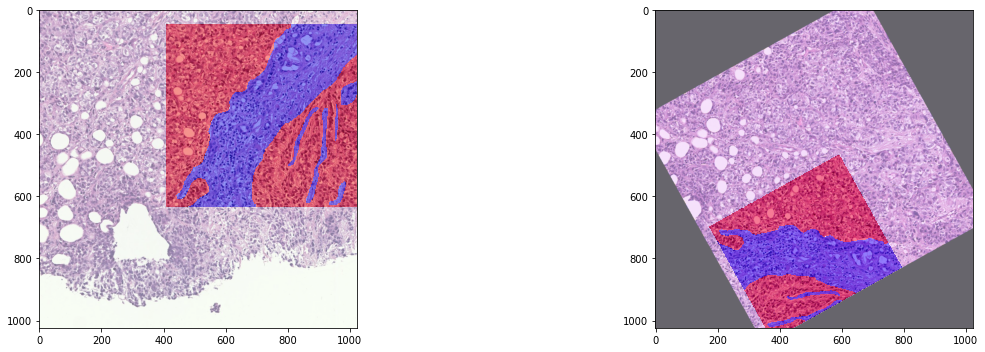

^ spatial


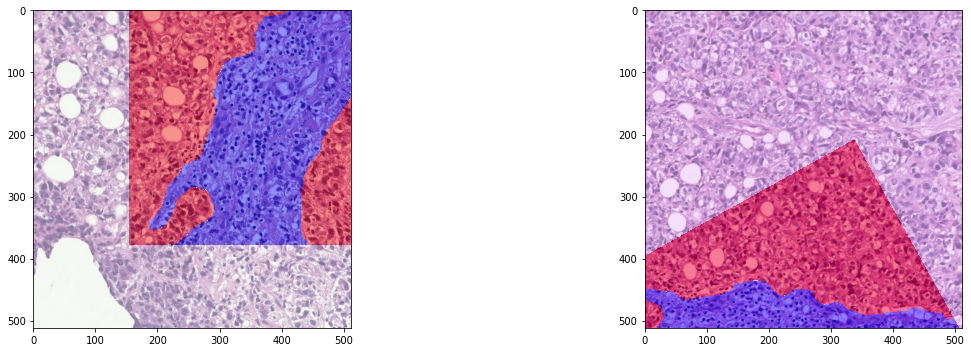

In [37]:
# #need to run the config cell again to correctly set new seed
seed = int(str(time.time())[-3:])
print(seed)
user_config['wholeslidedata']['default']['seed']=seed
with create_batch_iterator(user_config=user_config, 
                           context='spawn' if os.name=='nt' else 'fork',
                           mode='training',
                           buffer_dtype=np.uint8,
                           extras_shapes=extra_ds_shapes,
                           # iterator_class=WholeSlidePlainnnUnetBatchIterator
                          ) as training_batch_generator:
    for i in range(5):
        x_batch, y_batch, *extras, _  =  next(training_batch_generator)
        # break
        # break
        batch = x_batch, y_batch
        print(i)
        plot_batch(batch[0], batch[1])
        cropped_batch = [crop_data(batch[0], [512, 512]), crop_data(np.expand_dims(batch[1], -1), [512, 512]).squeeze()]
        plot_batch(cropped_batch[0], cropped_batch[1])
        for extra in extras:
            cropped_extra = crop_data(np.expand_dims(extra, -1), [shape//2 for shape in extra.shape[-2:]]).squeeze()

In [38]:
def half_crop(data):
    cropx = (data.shape[1] - data.shape[1]//2) // 2
    cropy = (data.shape[2] - data.shape[2]//2) // 2
    if len(data.shape) == 3:
        return data[:, cropx:-cropx, cropy:-cropy]
    if len(data.shape) == 4:
        return data[:, cropx:-cropx, cropy:-cropy, :]

In [39]:
crop_data(x_batch, [512, 512]).shape

(2, 512, 512, 3)

In [40]:
if torch.cuda.is_available():
    # Get the default CUDA device
    device = torch.cuda.current_device()

    # Get the GPU properties
    gpu_properties = torch.cuda.get_device_properties(device)

    # Retrieve the GPU memory size in bytes
    gpu_memory_bytes = gpu_properties.total_memory

    # Convert bytes to gigabytes
    gpu_memory_gb = gpu_memory_bytes / 1e9

    print(f"GPU Memory Size: {gpu_memory_gb:.2f} GB")
else:
    print("No GPU available.")

GPU Memory Size: 11.55 GB


In [ ]:
int(11.9)

In [ ]:
import multiprocessing

cpu_count = multiprocessing.cpu_count()
print(f"Number of CPUs: {cpu_count}")

In [ ]:
def get_cpu_limit():
    with open("/sys/fs/cgroup/cpu/cpu.cfs_quota_us") as fp:
        cfs_quota_us = int(fp.read())
    with open("/sys/fs/cgroup/cpu/cpu.cfs_period_us") as fp:
        cfs_period_us = int(fp.read())
    container_cpus = cfs_quota_us // cfs_period_us
    # For physical machine, the `cfs_quota_us` could be '-1'
    cpus = cpu_count() if container_cpus < 1 else container_cpus
    return cpus

In [ ]:
get_cpu_limit()

18

In [ ]:
data = x_batch
data.shape

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the default CUDA device
    device = torch.cuda.current_device()

    # Get the GPU properties
    gpu_properties = torch.cuda.get_device_properties(device)

    # Retrieve the GPU memory size in bytes
    gpu_memory_bytes = gpu_properties.total_memory

    # Convert bytes to gigabytes
    gpu_memory_gb = gpu_memory_bytes / 1e9

    print(f"GPU Memory Size: {gpu_memory_gb:.2f} GB")
else:
    print("No GPU available.")

GPU Memory Size: 11.55 GB


In [ ]:
import psutil

def get_cpu_limit():
    # Get the number of available logical CPUs
    cpus = psutil.cpu_count(logical=True)

    # Get the CPU affinity of the current process
    cpu_affinity = psutil.Process().cpu_affinity()

    # If CPU affinity is set, return the number of CPUs in the affinity set
    if cpu_affinity:
        return len(cpu_affinity)

    # Return the total number of available CPUs if no CPU affinity is set
    return cpus

get_cpu_limit()

88

In [ ]:
cropx = (data.shape[0] - 512) // 2
cropy = (data.shape[1] - output_shape[1]) // 2

In [ ]:
device = torch.device('cuda')

In [ ]:
#need to run the config cell again to correctly set new seed
seed = int(str(time.time())[-3:])
print(seed)
user_config['wholeslidedata']['default']['seed']=seed
with create_batch_iterator(user_config=user_config, 
                           context='spawn' if os.name=='nt' else 'fork',
                           mode='training',
                           buffer_dtype=np.uint8,
                           extras_shapes=extra_ds_shapes,
                           iterator_class=WholeSlidePlainnnUnetBatchIterator
                          ) as training_batch_generator:
    for i in range(1):
        batch  =  next(training_batch_generator)
        

IndentationError: expected an indented block (2114068762.py, line 14)

In [ ]:
x_batch, y_batch, *extras, _  =  next(training_batch_generator)
# break
# break
batch = x_batch, y_batch
print(i)
plot_batch(batch[0], batch[1])
cropped_batch = [crop_data(batch[0], [512, 512]), crop_data(np.expand_dims(batch[1], -1), [512, 512]).squeeze()]
plot_batch(cropped_batch[0], cropped_batch[1])
for extra in extras:
    cropped_extra = crop_data(np.expand_dims(extra, -1), [shape//2 for shape in extra.shape[-2:]]).squeeze()
    print(extra.shape, cropped_extra.shape)

AttributeError: 'int' object has no attribute 'cast'

In [ ]:
x_batch.shape

In [115]:
crop_data(x_batch, [512, 512]).shape

-255 256


(2, 512, 512, 3)

In [116]:
half_crop(x_batch).shape

(2, 512, 512, 3)

In [122]:
y_batch.shape

(2, 1024, 1024)

In [123]:
crop_data(np.expand_dims(y_batch, -1), [512, 512]).squeeze().shape

-255 256


(2, 512, 512)

In [124]:
half_crop(y_batch).shape

(2, 512, 512)

In [125]:
[extra.shape for extra in extras]

[(2, 512, 512),
 (2, 256, 256),
 (2, 128, 128),
 (2, 64, 64),
 (2, 32, 32),
 (2, 16, 16)]

In [60]:
extra_ds_sizes

[[512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]

In [59]:
[crop_data(np.expand_dims(extra, -1), [512, 512]).squeeze().shape for extra in extras]

[(2, 512, 512),
 (2, 256, 256),
 (2, 128, 128),
 (2, 64, 64),
 (2, 32, 32),
 (2, 16, 16)]

In [37]:
crop_data(x_batch.shape

(2, 1024, 1024, 3)

In [35]:
x_batch, y_batch, *extras, _  

(array([[[[230, 240, 254],
          [230, 240, 254],
          [229, 240, 253],
          ...,
          [227, 240, 252],
          [226, 240, 251],
          [226, 240, 251]],
 
         [[230, 240, 254],
          [230, 240, 254],
          [229, 240, 253],
          ...,
          [229, 240, 254],
          [228, 240, 253],
          [227, 240, 252]],
 
         [[229, 240, 253],
          [229, 240, 253],
          [229, 240, 253],
          ...,
          [229, 240, 254],
          [228, 240, 253],
          [227, 240, 252]],
 
         ...,
 
         [[127,  97, 142],
          [154, 122, 171],
          [181, 149, 201],
          ...,
          [173, 152, 201],
          [175, 155, 202],
          [179, 164, 207]],
 
         [[151, 119, 171],
          [178, 145, 200],
          [196, 164, 220],
          ...,
          [171, 149, 194],
          [170, 151, 193],
          [180, 164, 206]],
 
         [[174, 144, 200],
          [199, 167, 226],
          [208, 174, 232],
   

In [69]:
extra.shape[-2:]

(16, 16)

In [58]:
y_batch.shape

(2, 1024, 1024)

In [29]:
extra.shape

(2, 16, 16)

In [31]:
np.expand_dims(extra, -1).shape

(2, 16, 16, 1)

In [38]:
crop_data(np.expand_dims(extra, -1), [8, 8]).squeeze()

array([[[0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 2],
        [0, 0, 0, 0, 2, 1, 2, 2],
        [0, 0, 0, 0, 1, 2, 2, 2],
        [0, 0, 0, 0, 2, 2, 2, 2],
        [0, 0, 0, 0, 2, 2, 2, 2]],

       [[0, 1, 2, 2, 2, 2, 1, 1],
        [0, 1, 2, 2, 2, 1, 1, 1],
        [0, 1, 1, 2, 2, 2, 2, 2],
        [0, 1, 1, 1, 2, 2, 2, 1],
        [0, 1, 1, 1, 1, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [39]:
extra.shape

(2, 16, 16)

In [32]:
cropped_extra

array([], shape=(2, 0, 0), dtype=uint8)

In [45]:
[shape//2 for shape in extra.shape[-2:]]

[256, 256]

In [46]:
for extra in extras:
    cropped_extra = crop_data(np.expand_dims(extra, -1), [shape//2 for shape in extra.shape[-2:]]).squeeze()
    print(extra.shape, cropped_extra.shape)

(2, 512, 512) (2, 256, 256)
(2, 256, 256) (2, 128, 128)
(2, 128, 128) (2, 64, 64)
(2, 64, 64) (2, 32, 32)
(2, 32, 32) (2, 16, 16)
(2, 16, 16) (2, 8, 8)


In [14]:
batch[0][0].dtype

dtype('uint16')

In [ ]:
crop_data(batch[0], [512, 512]).shape

In [11]:
len(batch)

3

In [12]:
plt.imshow(batch['data'][0].transpose(1, 2, 0))

TypeError: list indices must be integers or slices, not str

In [ ]:
batch

In [ ]:
batch['data'][0]

In [ ]:
x_ex = [np.ones((512, 512, 3)), np.ones((512, 512, 3))]

In [ ]:
np.stack([x for x in x_ex]).transpose((0, 3, 1, 2)).shape

In [ ]:
np.concatenate(x_ex, axis=0).shape

In [ ]:
batch['data'].shape

In [ ]:
batch['target'].shape

In [ ]:
batch

In [ ]:
batch['data'].shape

In [ ]:
batch['seg'].shape

In [ ]:
x_batch.shape

In [ ]:
y_batch.shape